# Segmentation Pipeline

This notebook contains examples of how to use the full segmentation pipeline to train, evaluate, and perform inference.

## Prepare notebook

We now set the current working directory, and load parameters from a configuration file.

In [1]:
import os
import yaml
import argparse


# Save program's directory
cwd = os.getcwd()
if cwd == '/content':  # If we are in colab, we mount drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Change dir to where project is located
    os.chdir("drive/MyDrive/CoVision/segmentation")
    cwd = os.getcwd()
elif 'drive' in cwd:  # Already monted and changed dir
    pass
elif 'notebooks' in os.listdir(cwd):  # Local machine case
    cwd = './'
else:  # If currently in notebook folder
    os.chdir('./..')
    cwd = './'
print(f'Current working directory: {cwd}\n')

# Read arguments from dict and store them as Namespace
with open(cwd + 'config.yaml', 'r') as f:
    config_dict = yaml.safe_load(f)

# Update directories for colab
config_dict['data_args']['data_dir'] = os.path.join(cwd, config_dict['data_args']['data_dir'])
config_dict['training_args']['save_path'] = os.path.join(cwd, config_dict['training_args']['save_path'])
config_dict['inference_args']['output_dir'] = os.path.join(cwd, config_dict['inference_args']['output_dir'])

args = argparse.Namespace(**config_dict)
data_args = argparse.Namespace(**config_dict['data_args'])
training_args = argparse.Namespace(**config_dict['training_args'])
transformation_args = argparse.Namespace(**config_dict['transformation_args'])
inference_args = argparse.Namespace(**config_dict['inference_args'])

print(data_args, '\n')
print(training_args, '\n')
print(transformation_args, '\n')
print(inference_args, '\n')

# To reaload packages and modules automatically! Super useful to avoid double coding
%load_ext autoreload
%autoreload 2

Current working directory: ./

Namespace(class_colors=[[255, 0, 0], [0, 0, 255], [0, 255, 0]], class_ids=[0, 1, 2], classes=['background', 'kit', 'membrane'], data_dir='./data', resize_height=800, train_test_split=0.8, train_val_split=0.8) 

Namespace(batch_size=4, epochs=10, hidden_size=256, lr='5e-5', num_workers=0, save_path='./models', scheduler_gamma=0.5, scheduler_step=10, seed=42) 

Namespace(affine_p=0.5, affine_scale=[1, 1.5], affine_translate_percent=[-0.1, 0.1], blur_limit=5, blur_p=0.8, color_jitter_brightness=0.1, color_jitter_contrast=0.1, color_jitter_p=0.5, color_jitter_saturation=0.1, downscale_max=0.35, downscale_min=0.2, downscale_p=0.5, gauss_noise_p=0.5, gauss_noise_var_limit=[50, 100], horizontal_flip_p=0.5, perspective_p=0.5, perspective_scale=[0.05, 0.1], rotate_limit=80, rotate_p=0.8) 

Namespace(mask_thresholds=[0.7, 0.7], output_dir='./results', score_thresholds=[0.85, 0.85]) 



## Prepare data

This section contains the steps to follow for bringing the raw images and masks into datasets as required for training and testing the segmentation model. Given a new kit, e.g. deepblueag, the raw data must be split into train, validation, and test sets. In order to do so we use the custom function `build_filenames_file`.

In [2]:
import pandas as pd

from src.data.preprocessing import split_data

In [3]:
kit_id='paramountag'
split_data(data_args, kit_id)

File ./data/paramountag/paramountag_filenames.csv already exists! Do you want to overwrite it? (y/n): n


SystemExit: The file was not overwritten :)

/home/guybrush/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3513: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [4]:
filenames_df = pd.read_csv(os.path.join(data_args.data_dir, kit_id, f'{kit_id}_filenames.csv'), index_col=0)
print(filenames_df.value_counts('data_mode'))
filenames_df.head(10)

data_mode
train    27
test      9
val       7
dtype: int64


data_mode
IMG_0776     train
IMG_0688       val
IMG_1434     train
IMG_0689     train
IMG_1458      test
IMG_1414      test
IMG_0708     train
IMG_0765     train
IMG_1464      test
IMG_1474     train

## Model train

We use this section to train the model

In [5]:
from src.models.model_train import TrainerSegmentation
from src.utils.visualization import plot_metrics

/usr/lib/python3/dist-packages/mpmath/ctx_mp_python.py:873: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if other is 0:
/usr/lib/python3/dist-packages/mpmath/ctx_mp_python.py:967: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if other is 0:
/usr/lib/python3/dist-packages/sympy/solvers/diophantine.py:3188: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if feasible is 1:  # it's prime and k == 2


In [6]:
# Set some training parameters (for hyperparameter search)
args.training_args['epochs'] = 1
args.training_args['num_workers'] = 2
args.training_args['batch_size'] = 8
args.training_args['learning_rate'] = 1e-4
args.training_args['scheduler_step'] = 20
args.training_args['scheduler_gamma'] = 0.5

args.inference_args['mask_thresholds'] = [0.75, 0.75]

# To train from scratch
trainer = TrainerSegmentation(args=args, kit_id='aconag', do_validation=True, val_set='val', shots=10)

# To resume from saved state
# state_path = os.path.join(cwd + 'saved_models/2024-03-06_13.04.44_best.state')
# trainer = TrainerSegmentation.from_saved_state(state_path, new_epochs=150)

Using cpu device
Random seed set as 42
Loading data...
Loaded 10 image and mask paths for aconag test kit in train data mode
Loaded 7 image and mask paths for aconag test kit in val data mode


In [7]:
# trainer.train(save_bool=True)

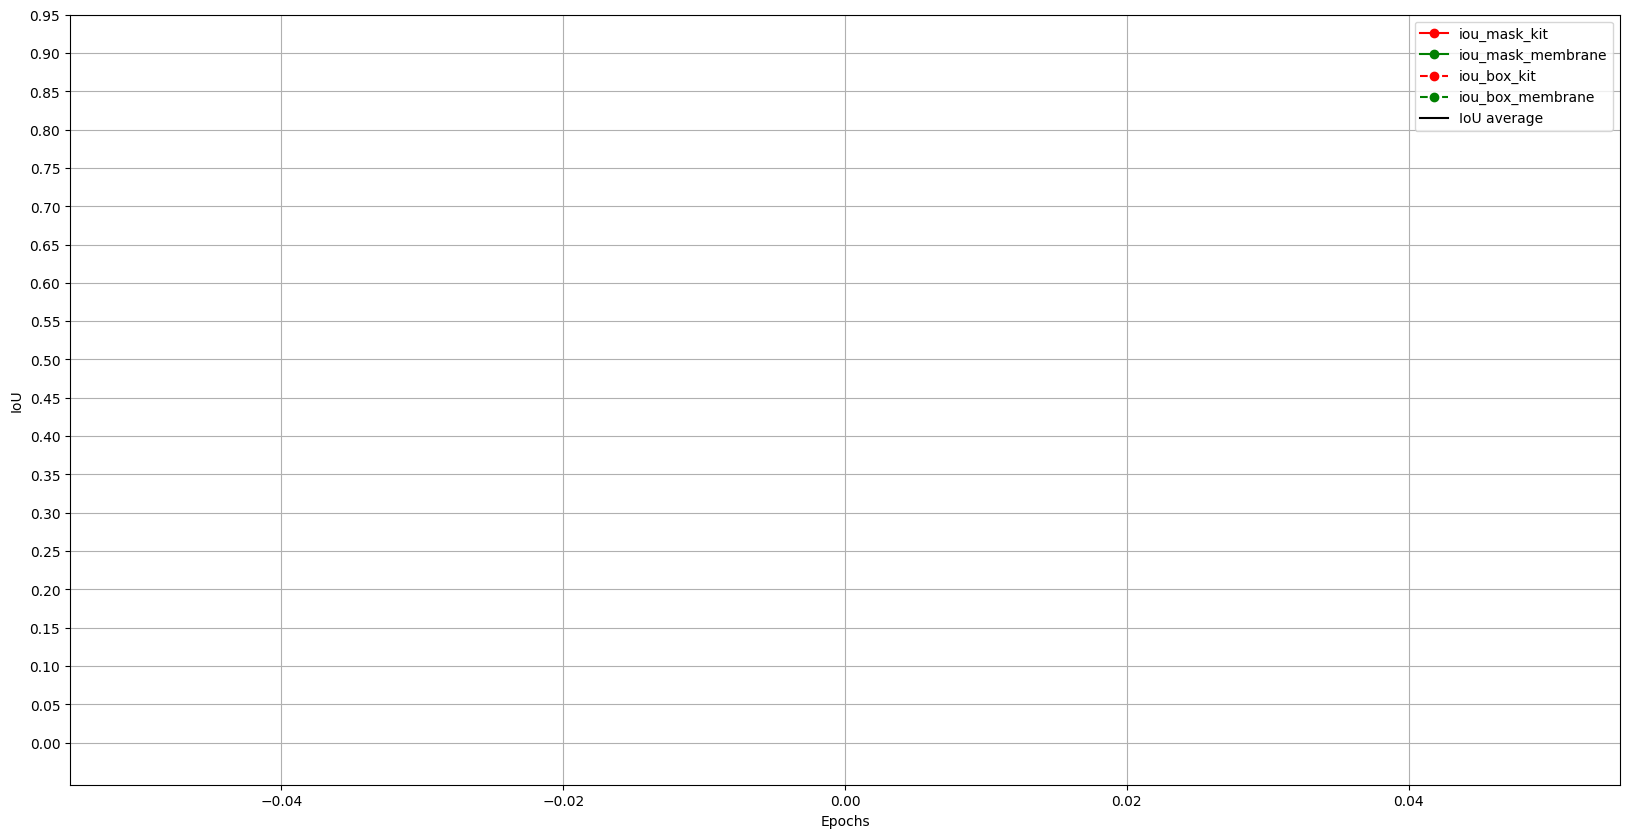

In [8]:
metrics_train_df, metrics_val_df = trainer.get_metrics()
plot_metrics(metrics_val_df)

## Model evaluation

In this section we evaluate models on different datasets, like train, val and test sets.

In [10]:
import torch 

from src.models.model_evaluate import EvalSegmentation
from src.models.model_architecture import get_segmentation_model

In [11]:
# Load trained model's state
state_path = os.path.join(training_args.save_path, '2024-03-06_13.04.44_best.state')
state = torch.load(state_path, map_location='cpu')
model = get_segmentation_model(len(data_args.classes), training_args.hidden_size)
model.load_state_dict(state['model_state'])

<All keys matched successfully>

In [12]:
tester = EvalSegmentation(args, model=model, device=None)

Loaded 7 image and mask paths for aconag test kit in val data mode


  0%|          | 0/4 [00:00<?, ?it/s]

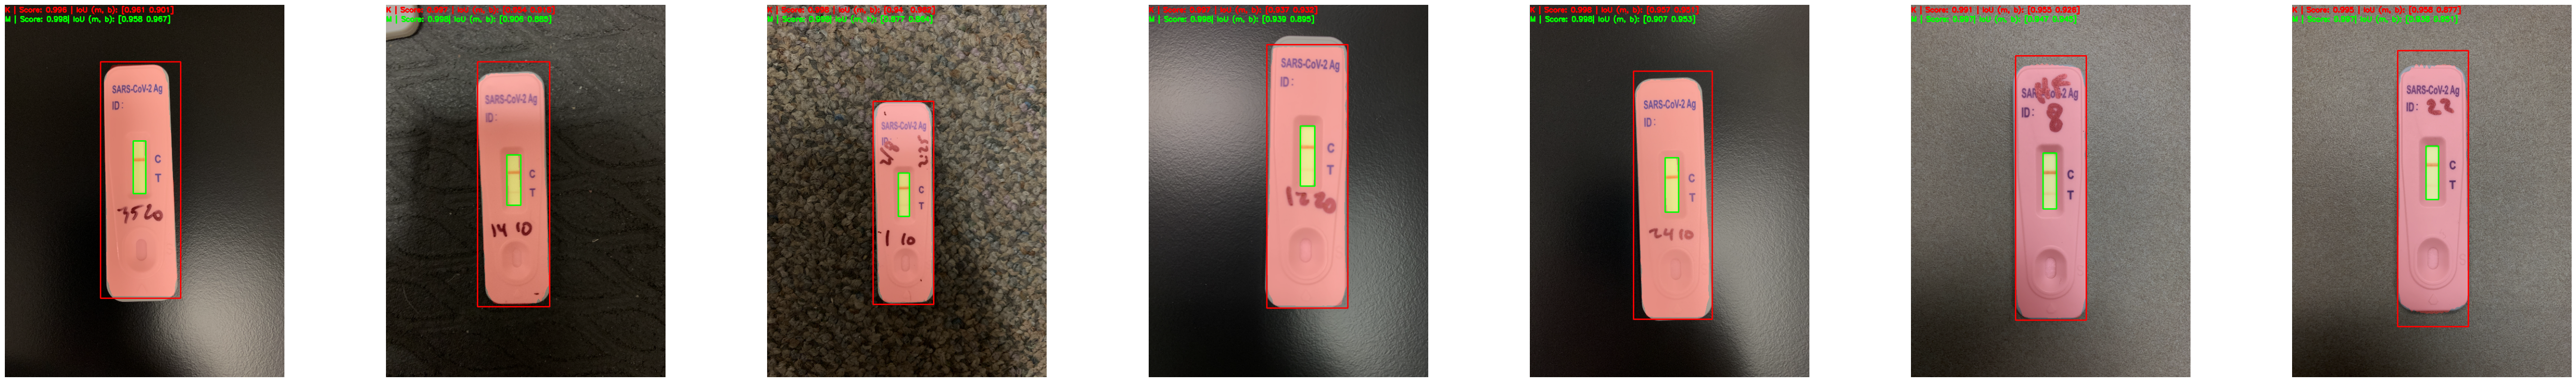

Mean metrics
scores_kit: 0.9959
scores_membrane: 0.9978
iou_masks_kit: 0.9516
iou_masks_membrane: 0.9247
iou_boxes_kit: 0.9268
iou_boxes_membrane: 0.9228


In [14]:
kit_id = 'aconag'
data_mode = 'val'
metrics_test_df = tester.evaluate(kit_id=kit_id, data_mode=data_mode, show_bool=True, save_bool=False, save_filename='v0')

## Membrane extractor

This final part of the pipeline takes a raw image as input and returns a crop of the membrane.

In [15]:
import torch
import pandas as pd
import cv2

from src.models.membrane_extractor import extract_corrected_membrane
from src.models.model_architecture import get_segmentation_model
from src.utils.visualization import show_membranes

In [16]:
# Load trained model's state
state_path = os.path.join(training_args.save_path, '2024-03-06_13.04.44_best.state')
state = torch.load(state_path, map_location='cpu')
model = get_segmentation_model(len(data_args.classes), training_args.hidden_size)
model.load_state_dict(state['model_state'])

<All keys matched successfully>

In [17]:
# Get images from local folder
kit_id = 'paramountag'
data_mode = 'test'

# Load full image paths of corresponding data_mode
filenames_df = pd.read_csv(os.path.join(data_args.data_dir, kit_id, f'{kit_id}_filenames.csv'), index_col=0)
filenames = filenames_df[filenames_df.data_mode == data_mode].index.to_list()
image_paths = [os.path.join(data_args.data_dir, kit_id, f'{kit_id}_images', f'{n}.jpg') for n in filenames]

Rotated angle: 6
Kit, Membrane scores: (0.993, 0.998)
Rotated angle: 4
Kit, Membrane scores: (0.996, 0.997)
Rotated angle: 8
Kit, Membrane scores: (0.995, 0.998)
Rotated angle: 0
Kit, Membrane scores: (0.995, 0.998)
Rotated angle: 0
Kit, Membrane scores: (0.997, 0.997)
Rotated angle: 0
Kit, Membrane scores: (0.997, 0.998)
Rotated angle: 8
Kit, Membrane scores: (0.995, 0.998)
Rotated angle: 1
Kit, Membrane scores: (0.967, 0.903)
Rotated angle: -1
Kit, Membrane scores: (0.996, 0.998)


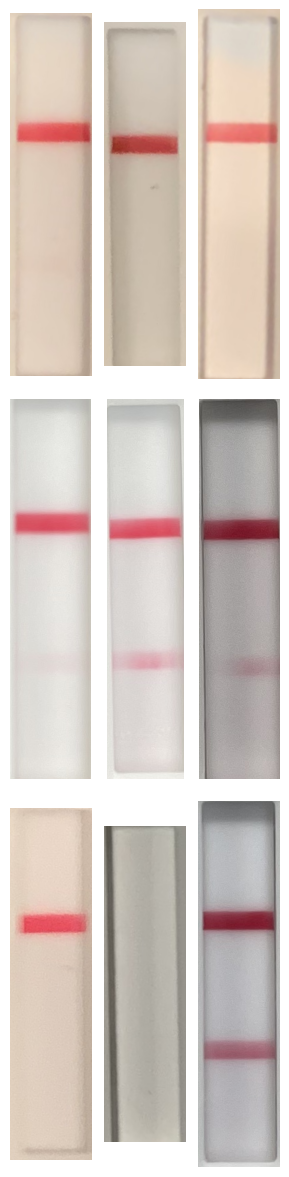

In [18]:
# Extract membranes from several images
membranes_list = []
for path in image_paths:
    image = cv2.imread(path)
    membrane, *_ = extract_corrected_membrane(data_args, inference_args, image, model, return_mask=False)
    membranes_list.append(membrane)
    
# Display images
show_membranes(membranes_list)